## Regresión lineal múltiple

Predecir la variable numérica continua charges

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
df = pd.read_csv('../../data/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## EDA

* pairplot
* heatmap
* scatterplot

Detectar qué columnas afectan más a charges

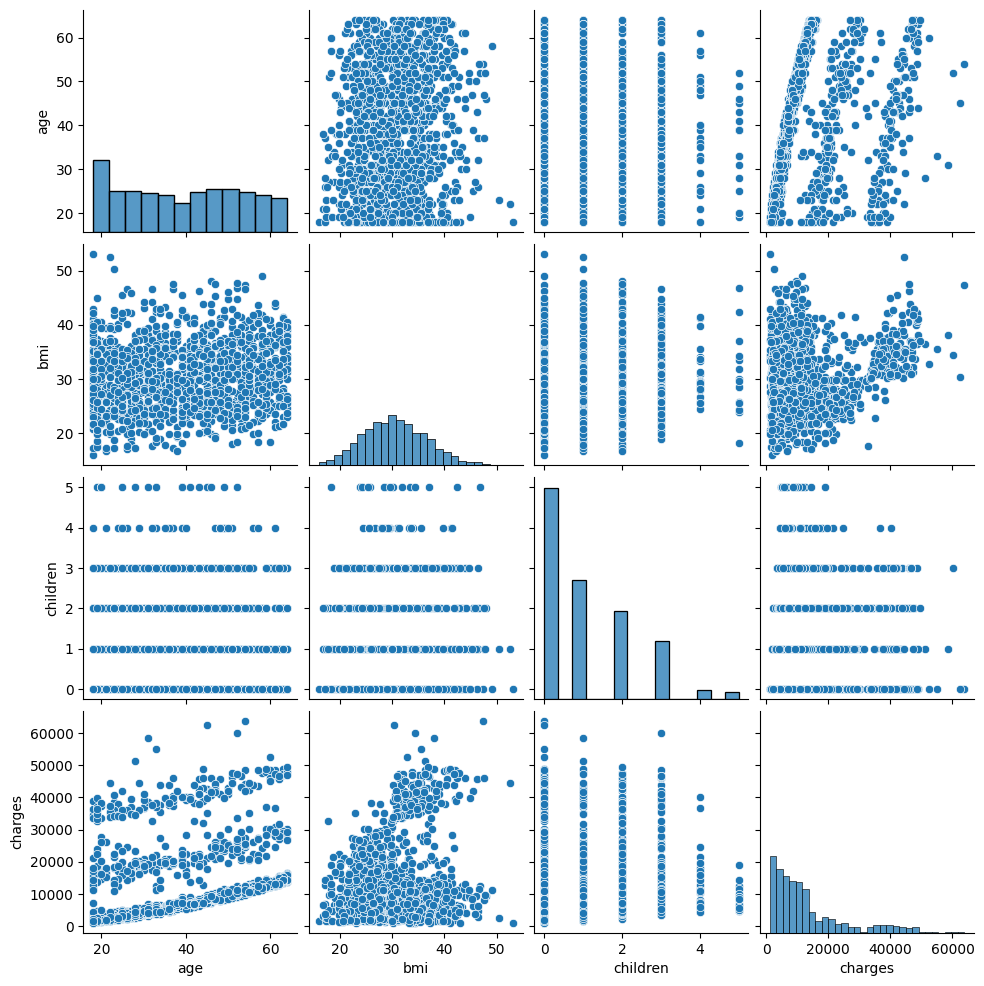

In [4]:
sns.pairplot(df)

<Axes: xlabel='bmi', ylabel='charges'>

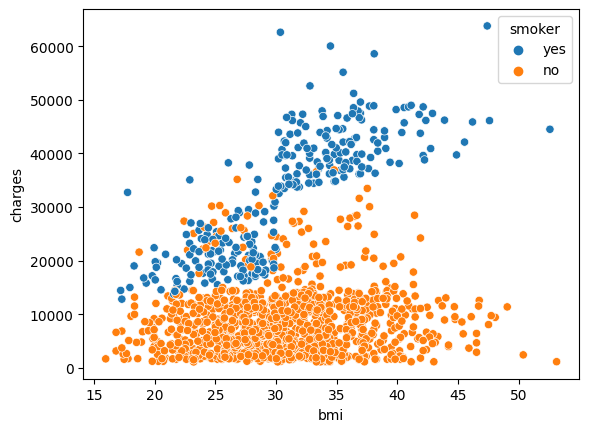

In [5]:
sns.scatterplot(data=df, x='bmi', y='charges', hue='smoker')

<Axes: xlabel='age', ylabel='charges'>

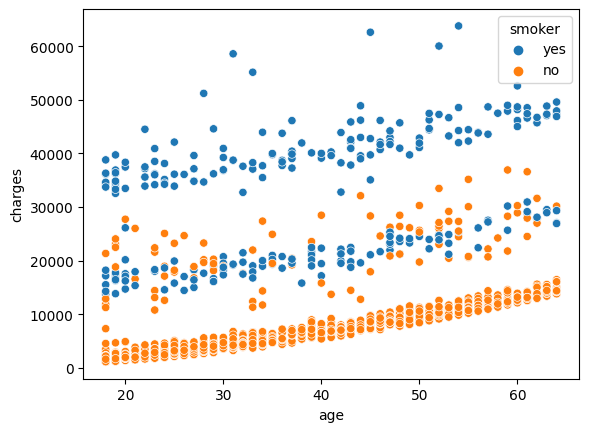

In [6]:
sns.scatterplot(data=df, x='age', y='charges', hue='smoker')

<Axes: xlabel='age', ylabel='charges'>

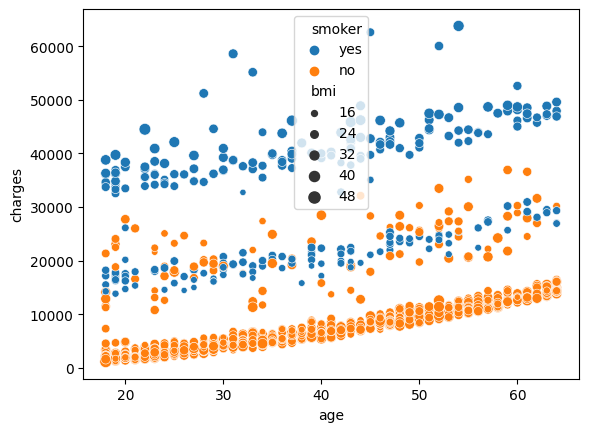

In [7]:
sns.scatterplot(data=df, x='age', y='charges', hue='smoker', size='bmi')

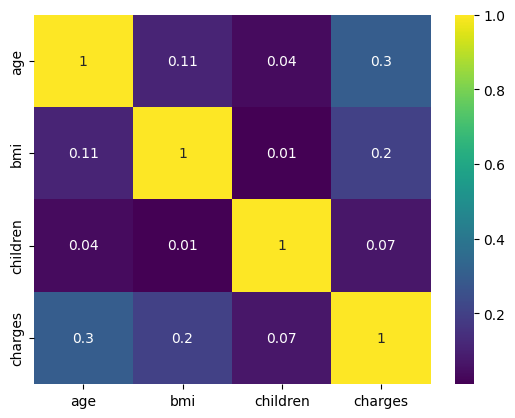

In [9]:
df_corr = df.corr(numeric_only=True).round(2)
sns.heatmap(df_corr, cmap='viridis', annot=True);

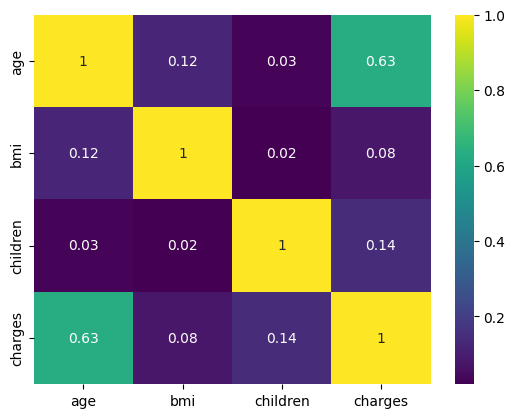

In [11]:
filter = df['smoker'] == 'no'
df_non_smoker = df[filter]
df_corr = df_non_smoker.corr(numeric_only=True).round(2)
sns.heatmap(df_corr, cmap='viridis', annot=True);

## Regresión lineal simple

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


X = df[['age']] # entrada
y = df['charges'] # salida

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
model = LinearRegression()
model.fit(X_train, y_train) # entrenamiento 

LinearRegression()

In [14]:
y_pred = model.predict(X_test) # predicción

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"rmse: {mean_squared_error(y_test, y_pred, squared=False)}")

mae: 9173.258196746589
rmse: 11661.21595205864


## Regresión lineal simple: age by smoker

In [20]:
df_smoker = df[df['smoker'] == 'yes']

X = df_smoker[['age']] # entrada
y = df_smoker['charges'] # salida

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test) 

# Para no fumadores se mejoran los resultados
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"rmse: {mean_squared_error(y_test, y_pred, squared=False)}")

mae: 11068.729655335137
rmse: 11843.915188904944


In [21]:
df_non_smoker = df[df['smoker'] == 'no']


X = df_non_smoker[['age']] # entrada
y = df_non_smoker['charges'] # salida

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test) 

# Para no fumadores se mejoran los resultados
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"rmse: {mean_squared_error(y_test, y_pred, squared=False)}")

mae: 2508.682862791196
rmse: 4427.536012763288


## Codificación categóricos a numéricos

sex, smoker, region a número

In [37]:
# codificar con .map
df['smoker_int'] = df['smoker'].map({'yes': 1, 'no': 0})
df['sex_int'] = df['sex'].map({'female': 1, 'male': 0})

In [38]:
# codificar con get_dummies
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [39]:
df_region = pd.get_dummies(df['region'])
df = pd.concat([df, df_region], axis=1)
df.head(2)

,age,sex,bmi,children,smoker,region,charges,smoker_int,sex_int,northeast,northwest,southeast,southwest
0,19,female,27.90,0,yes,southwest,16884.9240,1,1,0,0,0,1
1,18,male,33.77,1,no,southeast,1725.5523,0,0,0,0,1,0


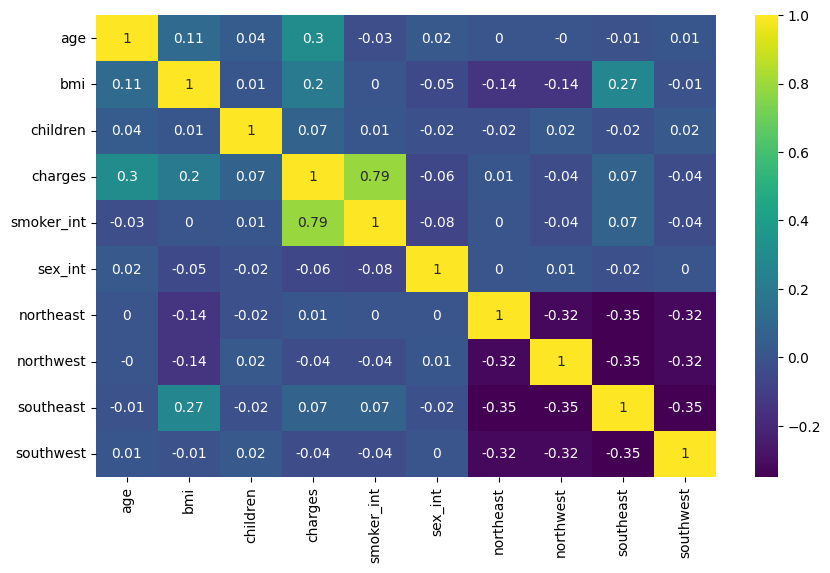

In [40]:
plt.figure(figsize=(10, 6))
df_corr = df.corr(numeric_only=True).round(2)
sns.heatmap(df_corr, cmap='viridis', annot=True);

## Regresión lineal múltiple

In [48]:
# columnas más correlacionadas: smoker_int, age, bmi

X = df[['smoker_int', 'age', 'bmi']]
y = df['charges']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test) 

print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"rmse: {mean_squared_error(y_test, y_pred, squared=False)}")


mae: 4260.560091099389
rmse: 5874.763304187488


In [49]:
# probar con todas las columnas
X = df[['smoker_int', 'age', 'bmi', 'sex_int', 'children', 'northeast', 'northwest', 'southeast', 'southwest']]
y = df['charges']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test) 

print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"rmse: {mean_squared_error(y_test, y_pred, squared=False)}")

mae: 4181.194473753648
rmse: 5796.2846592762735


## Eliminar outliers

Eliminar outliers y columnas correlacionadas entre sí.

In [50]:
def drop_outliers(df):
    df_copy = df.copy()

    for column in df_copy.columns:
        if df_copy[column].dtype == 'object':
            continue

        # borrar outliers en numéricos
        Q1 = df_copy[column].quantile(0.25)
        Q3 = df_copy[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        filter = (df_copy[column] >= lower_limit) & (df_copy[column] <= upper_limit)
        df_copy = df_copy[filter]

    return df_copy

In [51]:
df_no_outliers = drop_outliers(df)
print(f"df.shape: {df.shape}")
print(f"df_no_outliers.shape: {df_no_outliers.shape}")

df.shape: (1338, 13)
df_no_outliers.shape: (799, 13)


In [52]:
X = df_no_outliers[['smoker_int', 'age', 'bmi']]
y = df_no_outliers['charges']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test) 

print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"rmse: {mean_squared_error(y_test, y_pred, squared=False)}")

mae: 2302.498316263261
rmse: 4287.091583645905


In [53]:
# probar con todas las columnas
X = df_no_outliers[['smoker_int', 'age', 'bmi', 'sex_int', 'children', 'northeast', 'northwest', 'southeast', 'southwest']]
y = df_no_outliers['charges']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test) 

print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"rmse: {mean_squared_error(y_test, y_pred, squared=False)}")

mae: 2201.38642889536
rmse: 4216.260224388172


In [57]:
residuos = y_test - y_pred
residuos

1159   -1516.905376
1115   -1108.840378
112    -1864.459613
887    -2068.461585
119    -1734.931485
           ...     
972    -1142.404498
1335    -655.978785
1242    -767.623756
859     -560.026637
1125     162.523613
Name: charges, Length: 160, dtype: float64

<Axes: xlabel='charges', ylabel='Count'>

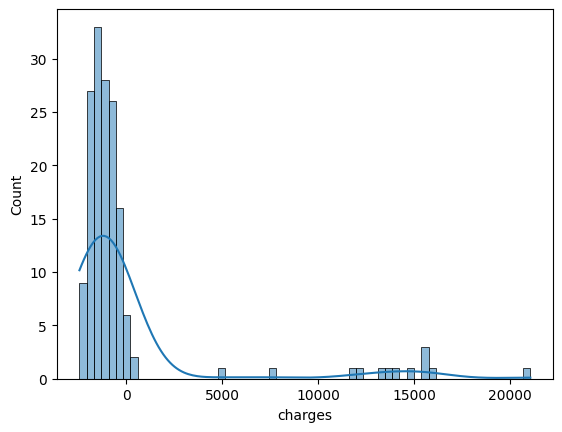

In [58]:
# residuos = diferencia entre valores reales y las predicciones
sns.histplot(residuos, kde=True)

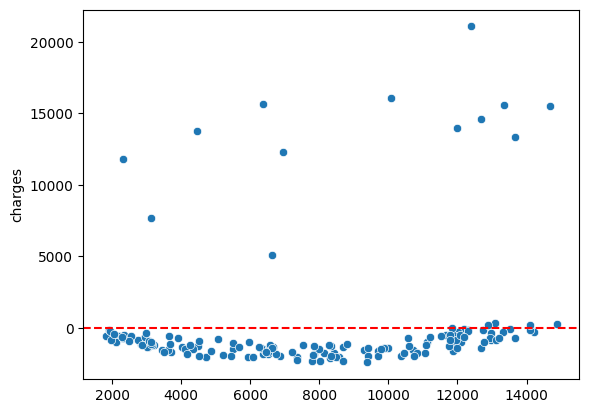

In [60]:
sns.scatterplot(x=y_pred, y=residuos)
plt.axhline(y=0, color='r', linestyle='--')